# About

These is a base solution of PID.

In [5]:
%matplotlib inline
import pandas
import numpy
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import TMVAClassifier

#RUN

In [6]:
params = {}

# Nets to track
params['TRACK'] = "Long" # "Long Downstream Upstream"
params['PARTICLE'] = "Electron" # "Electron Muon Pion Kaon Proton Ghost"

params['MVATYPE'] = "TMVA"


# General parameters
params['GHOSTACPTFRAC'] = 1.0
params['REUSETRAININGFILES'] = 0


# Overall root dir
params['MAINROOT'] = ""
# Config directory
params['CONFIGDIR'] = params['MAINROOT'] + "configs"


# Network config
params['CONFIGNAME'] = "NoPreSels-NumSPDR1R2"
params['NNCONFIGNAME'] = params['MVATYPE'] + "-" + params['CONFIGNAME']
params['NNCONFIGDIR'] = params['CONFIGDIR'] + "/networks/" + params['NNCONFIGNAME']
params['NETCONFIG'] = params['NNCONFIGDIR'] + "/" + \
                      "GlobalPID_" + params['PARTICLE'] + "_" + params['TRACK'] + "_ANN.txt"
    
# Training config
params['TRAINCONFIGNAME'] = "test-EqualSigBck"
params['TRAINCONFIGDIR'] = params['CONFIGDIR'] + "/training/"
params['TRAINCONFIG'] = params['TRAINCONFIGDIR'] + \
                        params['MVATYPE'] + "-" + params['TRAINCONFIGNAME'] + ".txt"

# Preselection configs
params['TRACKSELCONFIGDIR'] = params['CONFIGDIR'] + "/TrackSelection/"


# Training data
params['DATAFILES'] = "MC12"
params['TRAININGDATA'] = "Mixture"
params['TRAINFILES'] = params['TRAINCONFIGDIR'] + "/" + params['DATAFILES'] + "-TrainingFiles-" + \
                       params['TRAININGDATA'] + "-Cambridge.txt"
    
    
# Eval data
params['EVALDATA'] = "Mixture"
params['EVALFILES'] = params['TRAINCONFIGDIR'] + "/" + params['DATAFILES'] + "-TrainingFiles-" + \
                      params['EVALDATA'] + "-Cambridge.txt"


# Main training directory
params['TRAINLOC']=params['DATAFILES'] + "/Train" + params['TRAININGDATA'] + "/" + params['TRAINCONFIGNAME'] + \
                   "/GhostAccFrac" + str(params['GHOSTACPTFRAC']) + "/" + params['NNCONFIGNAME']

params['TRAINDIR'] = params['MAINROOT'] + "results/" + params['TRAINLOC']
params['TRAINDIR'] = params['TRAINDIR'] + "/" + params['PARTICLE'] + "/" + params['TRACK']


# Get train data

In [7]:
import os, sys
sys.path.append('src')

from get_train_data import get_train_data

data_signal, data_bkg, features = get_train_data(params, location='http')

The directory exist.
Names of train features were saved.
Initialisation is completed.
Start reading files.

Reading train data is completed.

Writing train data is completed.



# Prepare data

In [10]:
# To remove constant features
data_signal['TrackCloneDist'] *= 1 + 0.00001 * numpy.random.rand(len(data_signal)) 
data_bkg['TrackCloneDist'] *= 1 + 0.00001 * numpy.random.rand(len(data_bkg)) 

In [11]:
from sklearn.cross_validation import train_test_split

data_train_signal, data_test_signal = train_test_split(data_signal, test_size=0.3, random_state=42)
data_train_bkg, data_test_bkg = train_test_split(data_bkg, test_size=0.3, random_state=42)


train_data = pandas.concat([data_train_signal, data_train_bkg], axis=0)
train_labels = numpy.concatenate((numpy.ones(len(data_train_signal)), numpy.zeros(len(data_train_bkg))), axis=0)

test_data = pandas.concat([data_test_signal, data_test_bkg], axis=0)
test_labels = numpy.concatenate((numpy.ones(len(data_test_signal)), numpy.zeros(len(data_test_bkg))), axis=0)


training_mix = numpy.loadtxt(params['TRAINCONFIG'], dtype='S', delimiter='\n', comments='#')[5]
if "EqualSigBck" == training_mix:
    k = 1. * len(data_train_signal)/len(data_train_bkg)
else:
    k = 1.

    
sample_weight = numpy.concatenate((numpy.ones(len(data_train_signal)),
                                   k * numpy.ones(len(data_train_bkg))), axis=0)

# Train TMVA MLP

In [15]:
tmva_mlp = TMVAClassifier(method='kMLP',
                      features=features,
                      factory_options="V:!Silent:!Color:!DrawProgressBar",
                      H='true',
                      V='true',
                      EpochMonitoring='true',
                      HiddenLayers=1.4*len(features),
                      UseRegulator='true',
                      ConvergenceImprove = "1e-16",
                      ConvergenceTests = "15",
                      VarTransform = "Norm",
                      NCycles = 50,
                      NeuronType = "sigmoid",
                      TrainingMethod = "BP",
                      EstimatorType = "CE")


tmva_mlp.fit(train_data, train_labels, sample_weight=sample_weight)

TMVAClassifier(ConvergenceImprove='1e-16', ConvergenceTests='15',
        EpochMonitoring='true', EstimatorType='CE', H='true',
        HiddenLayers=49.0, NCycles=50, NeuronType='sigmoid',
        TrainingMethod='BP', UseRegulator='true', V='true',
        VarTransform='Norm',
        factory_options='V:!Silent:!Color:!DrawProgressBar:AnalysisType=Classification',
        features=['NumSPDHits', 'NumRich1Hits', 'NumRich2Hits', 'TrackP', 'TrackPt', 'TrackChi2PerDof', 'TrackNumDof', 'TrackLikelihood', 'TrackGhostProbability', 'TrackCloneDist', 'TrackFitTChi2', 'TrackFitTNDoF', 'RichUsedAero', 'RichUsedR1Gas', 'RichUsedR2Gas', 'RichAboveMuThres', 'RichAboveKaThres', 'Ri...MuonNShared', 'InAccEcal', 'EcalPIDe', 'EcalPIDmu', 'InAccHcal', 'HcalPIDe', 'HcalPIDmu', 'PrsPIDe'],
        method='kMLP')

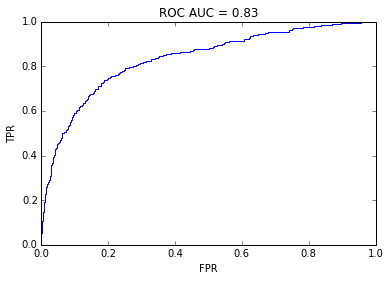

In [16]:
prob_mlp = tmva_mlp.predict_proba(test_data)

roc_auc = roc_auc_score(test_labels, prob_mlp[:, 1])
fpr, tpr, _ = roc_curve(test_labels, prob_mlp[:, 1])

plt.plot(fpr, tpr)
plt.title("ROC AUC = %.2f" % roc_auc)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

# Train TMVA BDT

In [12]:
tmva_bdt = TMVAClassifier(method='kBDT',
                      features=features,
                      factory_options="V:!Silent:!Color:!DrawProgressBar",
                      H='false',
                      V='true',
                      NTrees=800,
                      VarTransform = "Norm",
                      BoostType = "AdaBoost",
                      PruneMethod = "CostComplexity",
                      PruneStrength = -1,
                      MaxDepth = 3,
                      PruningValFraction = 0.3)

tmva_bdt.fit(train_data, train_labels, sample_weight=sample_weight)

TMVAClassifier(BoostType='AdaBoost', H='false', MaxDepth=3, NTrees=800,
        PruneMethod='CostComplexity', PruneStrength=-1,
        PruningValFraction=0.3, V='true', VarTransform='Norm',
        factory_options='V:!Silent:!Color:!DrawProgressBar:AnalysisType=Classification',
        features=['NumSPDHits', 'NumRich1Hits', 'NumRich2Hits', 'TrackP', 'TrackPt', 'TrackChi2PerDof', 'TrackNumDof', 'TrackLikelihood', 'TrackGhostProbability', 'TrackFitMatchChi2', 'TrackCloneDist', 'TrackFitVeloChi2', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'TrackFitTNDoF', 'RichUsedAero', 'RichUsedR1Gas',... 'EcalPIDe', 'EcalPIDmu', 'HcalPIDe', 'HcalPIDmu', 'PrsPIDe', 'InAccBrem', 'BremPIDe', 'VeloCharge'],
        method='kBDT')

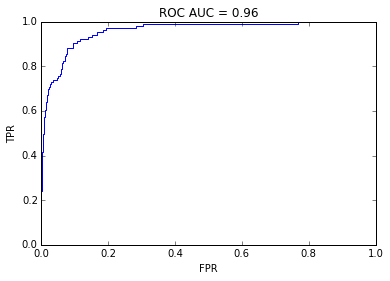

In [13]:
prob_bdt = tmva_bdt.predict_proba(test_data)

roc_auc = roc_auc_score(test_labels, prob_bdt[:, 1])
fpr, tpr, _ = roc_curve(test_labels, prob_bdt[:, 1])

plt.plot(fpr, tpr)
plt.title("ROC AUC = %.2f" % roc_auc)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()